In [8]:
import pandas as pd
from fastai.collab import *
from fastai.tabular import *
import seaborn as sns



In [166]:
train = pd.read_csv('train.csv', delimiter=',', header = 0)
test = pd.read_csv('test.csv', delimiter=',', header = 0)
user_features = pd.read_csv('user-features.csv', delimiter = ',', header = 0)
item_features = pd.read_csv('item-features.csv', delimiter=',', header = 0)

In [167]:
train = train[train['item_id'] < 216]
item_features = item_features[item_features['item_id'] < 216]

In [168]:
users = train['user_id']
l = range(497)
removed = set()
for user in users:
    if user not in l:
        removed.add(user)
removed

set()

In [169]:
train.head()

,user_id,item_id,like,timestamp
1,378,172,1,1490936628
2,150,182,0,1490936650
3,455,17,0,1490936704
5,122,96,0,1490936768
6,216,129,0,1490936810


In [170]:
data = CollabDataBunch.from_df(train, seed=42, valid_pct=0.2)

In [171]:
data.show_batch()

user_id,item_id,target
167,128,0.0
246,92,0.0
411,121,0.0
197,173,0.0
152,213,0.0


In [172]:
y_range = [0, 1]
learn = collab_learner(data, n_factors=30, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time
0,0.246023,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


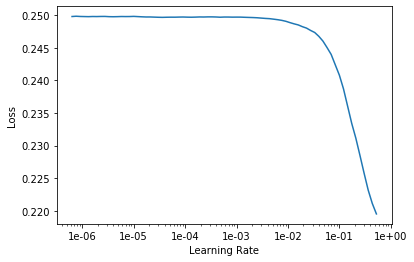

In [173]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [174]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.244842,0.236790,00:01
1,0.192139,0.144262,00:00
2,0.123569,0.110837,00:00
3,0.090345,0.104850,00:00
4,0.078213,0.104124,00:00


In [175]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(498, 30)
  (i_weight): Embedding(215, 30)
  (u_bias): Embedding(498, 1)
  (i_bias): Embedding(215, 1)
)

In [37]:
'''def score(learner, userIds, movieIds, user_col, item_col, prediction_col, top_k=20):
    """score all users+movies provided and reduce to top_k items per user if top_k>0"""
    u = learner.get_idx(userIds, is_item=False)
    m = learner.get_idx(movieIds, is_item=True)
    
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame({user_col: userIds, item_col:movieIds, prediction_col:pred})
    scores =  scores.sort_values([user_col,prediction_col],ascending=[True,False])
    if top_k > 0:
        top_scores = scores.groupby(user_col).head(top_k).reset_index(drop=True)
    else:
        top_scores = scores
    return top_scores'''

In [176]:
test_ids = test['user_id'].tolist()
n_items = item_features.shape[0]
#learn.model(torch.tensor([0]), torch.tensor(range(n_items)))

In [178]:
a = []
for user_x in test_ids:
    scores = learn.model(torch.tensor([user_x]), torch.tensor(np.arange(215)))
    score_dict = {i: scores[i] for i in range(len(scores))}
    top_20_items = [k for k, v in sorted(score_dict.items(), key=lambda item: item[1], reverse = True)]
    a.append([user_x] + top_20_items[:20])

In [179]:
a = np.array(a)
cols = ['user_id'] + [str(i) for i in range(20)]
ans = pd.DataFrame(data = a, columns = cols)
ans.head()

,user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,166,108,64,165,144,101,45,71,139,93,...,178,58,119,194,189,198,173,18,116,31
1,26,23,36,73,38,59,77,61,81,66,...,20,67,50,8,74,112,84,143,137,22
2,41,23,8,2,20,73,112,88,50,22,...,77,61,38,84,27,36,137,46,12,100
3,286,77,23,36,73,66,59,61,38,81,...,41,143,148,146,115,20,76,151,78,12
4,108,36,23,73,77,81,38,61,66,59,...,67,146,20,148,143,151,8,78,137,123


In [180]:
ans.to_csv('ans_2.csv', index = False)